# Hands-on Example: Computerized Tomography with Pyxu

This tutorial aims to introduce you to Pyxu fundamentals through the concrete example of tomographic reconstruction. In
this tutorial, we will cover a range of essential concepts and techniques, starting from the basics of defining the
forward model, moving on to traditional methods of image reconstruction, and then looking into advanced strategies like
model-based regularization and plug-and-play priors.

Let's get started!

## Tomographic Reconstruction in a Nutshell

Tomographic reconstruction is a computational process used in imaging sciences to reconstruct 2D or 3D images from a
series of projections captured at different angles. The term "tomography" stems from the Greek words "tomo," meaning
"slice" or "section", and "graph", meaning "to write" or "to record." In essence, tomography aims to construct a
representation of an object by investigating its internal structure slice-by-slice. This method has wide-ranging
applications, from medical imaging like [CT scans](https://www.radiologyinfo.org/en/info.cfm?pg=bodyct) to industrial
quality control, [seismology](https://earthquake.usgs.gov/learn/glossary/?term=seismic%20tomography), material science,
and [astronomy](https://www.annualreviews.org/doi/full/10.1146/annurev-astro-081817-051819). For a deeper understanding,
various [resources](http://www.slaney.org/pct/pct-toc.html) on the mathematical and computational aspects are available.

The fundamental principle behind tomographic reconstruction is the Radon transform, mapping a function in 2D or 3D space
to a set of line integrals. In the context of medical imaging, these line integrals represent the attenuation of X-rays
as they pass through a human body. By capturing these attenuations from various angles, it is possible to reconstruct a
cross-sectional image of the internal structure.

The process typically involves the following steps:

1. **Data Acquisition:** Projection data is gathered from different angles, typically by rotating the X-ray source and
   detector around the object being imaged.
2. **Back-Projection:** The acquired projection data is then 'smeared' back across the imaging field for each angle.
3. **Reconstruction:** Various algorithms, such as Filtered Back-Projection (FBP) or iterative methods, are used to
   compute the original image from the smeared data.

<center>    
    
<img align="center" src="../_static/tutorial/tomography_example.gif" alt="Tomography" width=70%>
</center>

## A Non-Ideal Parallel-beam Tomographic Setup

In this tutorial, we explore the challenges of working with a non-idealized parallel-beam tomographic setup that
deviates from the assumptions usually made by traditional Radon transform models. The complexities of our setup include:

- **Detector Width**: Detectors feature non-negligible widths, hence perform *tube integrals* in place of *line
  integrals* assumed by the Radon transform. This results in a blurring effect in the so-called *sinogram* — a data
  representation that stacks 1D projections of an object at various angles.

- **X-ray Beam Intensity**: The X-ray beam's intensity tapers towards the edges, causing a similar *tapering* effect in
  the sinogram, which complicates the application of the standard Radon transform.

- **Probabilistic Element**: There's a chance that detector pixels might malfunction during each scan, introducing
  *missing values* in the sinogram.

The figure below juxtaposes two types of sinograms for a specific test object, known as a phantom: one represents the
idealized sinogram that Radon-based reconstruction algorithms typically assume, and the other illustrates the
non-idealized sinogram as captured by the instrument.

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import skimage as ski
import warnings as warn
import time as t
import xdesign as xd

warn.filterwarnings("ignore")
plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = False
plt.rcParams["image.cmap"] = "inferno"

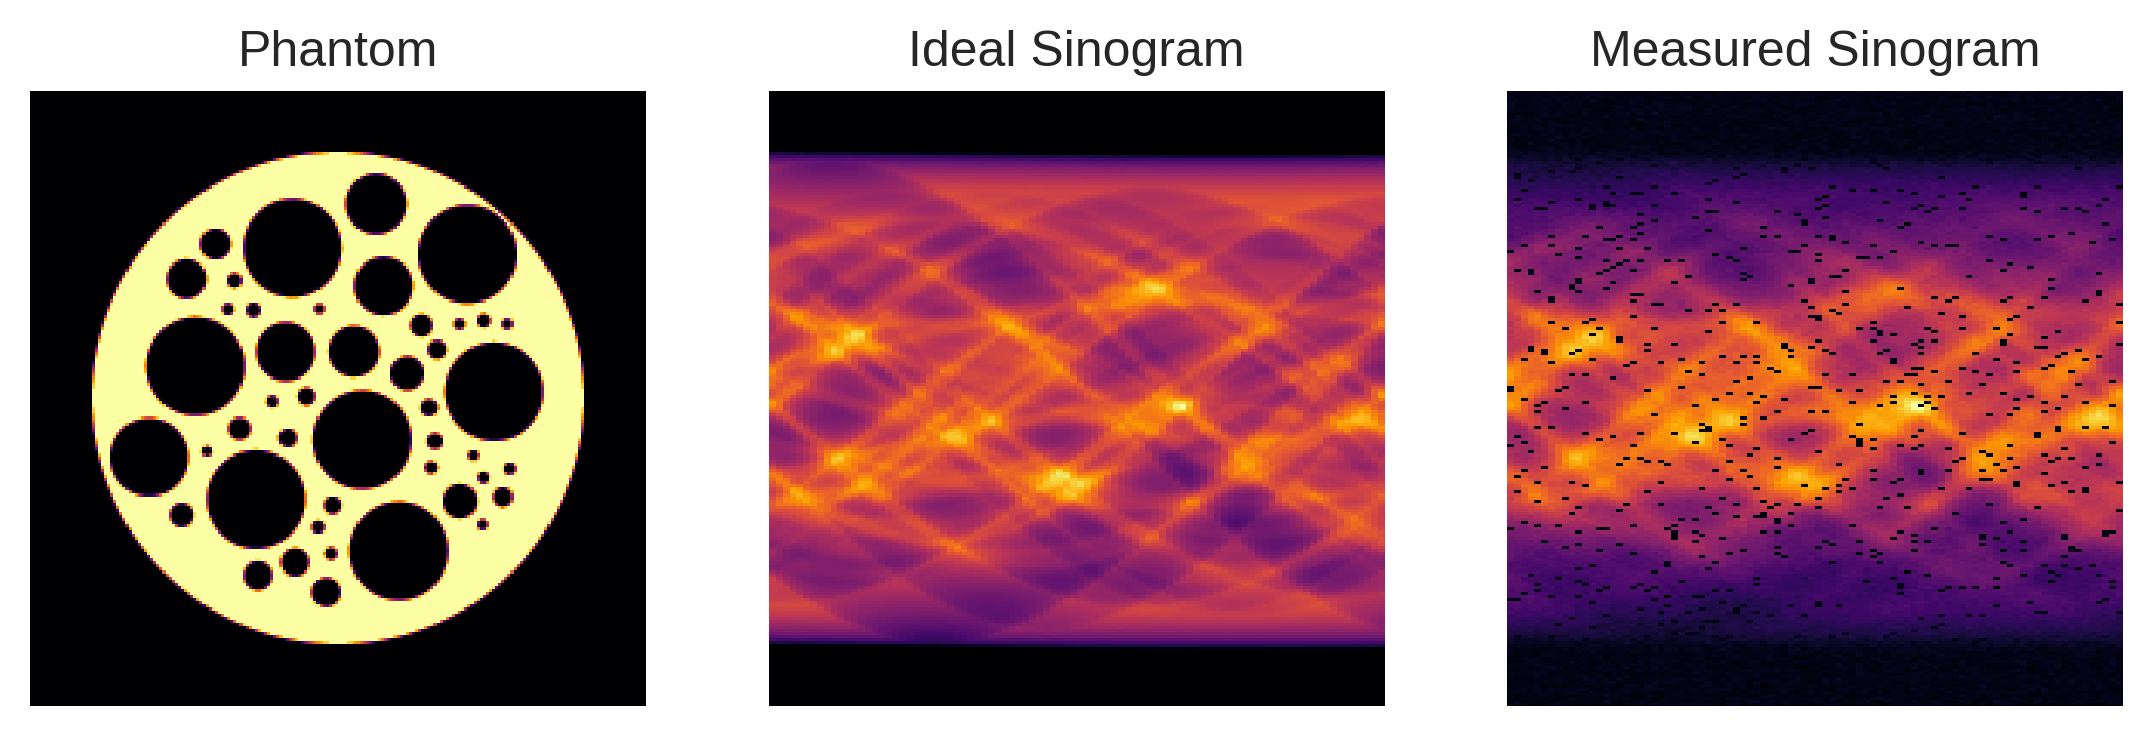

In [3]:
seed = 0

# Generate phantom with xdesign
np.random.seed(seed)
p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
phantom = xd.discrete_phantom(p1, 160) * 10
phantom = np.abs(np.pad(phantom, 20))

# Generate theoretical and empirical sinogram 
rng = np.random.default_rng(seed)
psnr = 20
angles, wsize = 90, 5
ideal_sino = ski.transform.radon(phantom, theta=np.linspace(0, 180, angles), circle=True)
sino = sp.ndimage.uniform_filter(ideal_sino, [wsize, 0], mode='constant')
mask = rng.binomial(1, 0.95, sino.shape)
sino *= mask
sino *= sp.signal.get_window('hamming', sino.shape[0])[:, None]
sigma = np.abs(sino).max() * (10**(-psnr/10))
sino += rng.normal(scale=sigma, size=sino.shape)

# Plot phantom and sinograms
plt.subplot(1,3,1)
plt.imshow(phantom)
plt.title("Phantom")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(ideal_sino, aspect=0.45)
plt.title("Ideal Sinogram")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(sino, aspect=0.45)
plt.title("Measured Sinogram")
plt.axis('off');

## Naive Application of Filtered-Back Projection

In this section, we explore what happens when we naively apply the `iradon()` function from the `scikit-image` library,
which implements the *Filtered Back Projection (FBP)* algorithm, without accounting for the non-idealities inherent to
our tomographic setup. Despite the algorithm's effectiveness in idealized scenarios, we observe that our reconstructed
image is riddled with severe artifacts.

We attempt to mitigate these artifacts by filling in the gaps in the sinogram through matched filtering. However, as can
be seen below, this approach proves insufficient for handling the complex distortions caused by the non-ideal conditions
in our setup. This section serves as a poignant illustration of the limitations of using off-the-shelf Radon transform
methods in scenarios that deviate from their underlying assumptions.

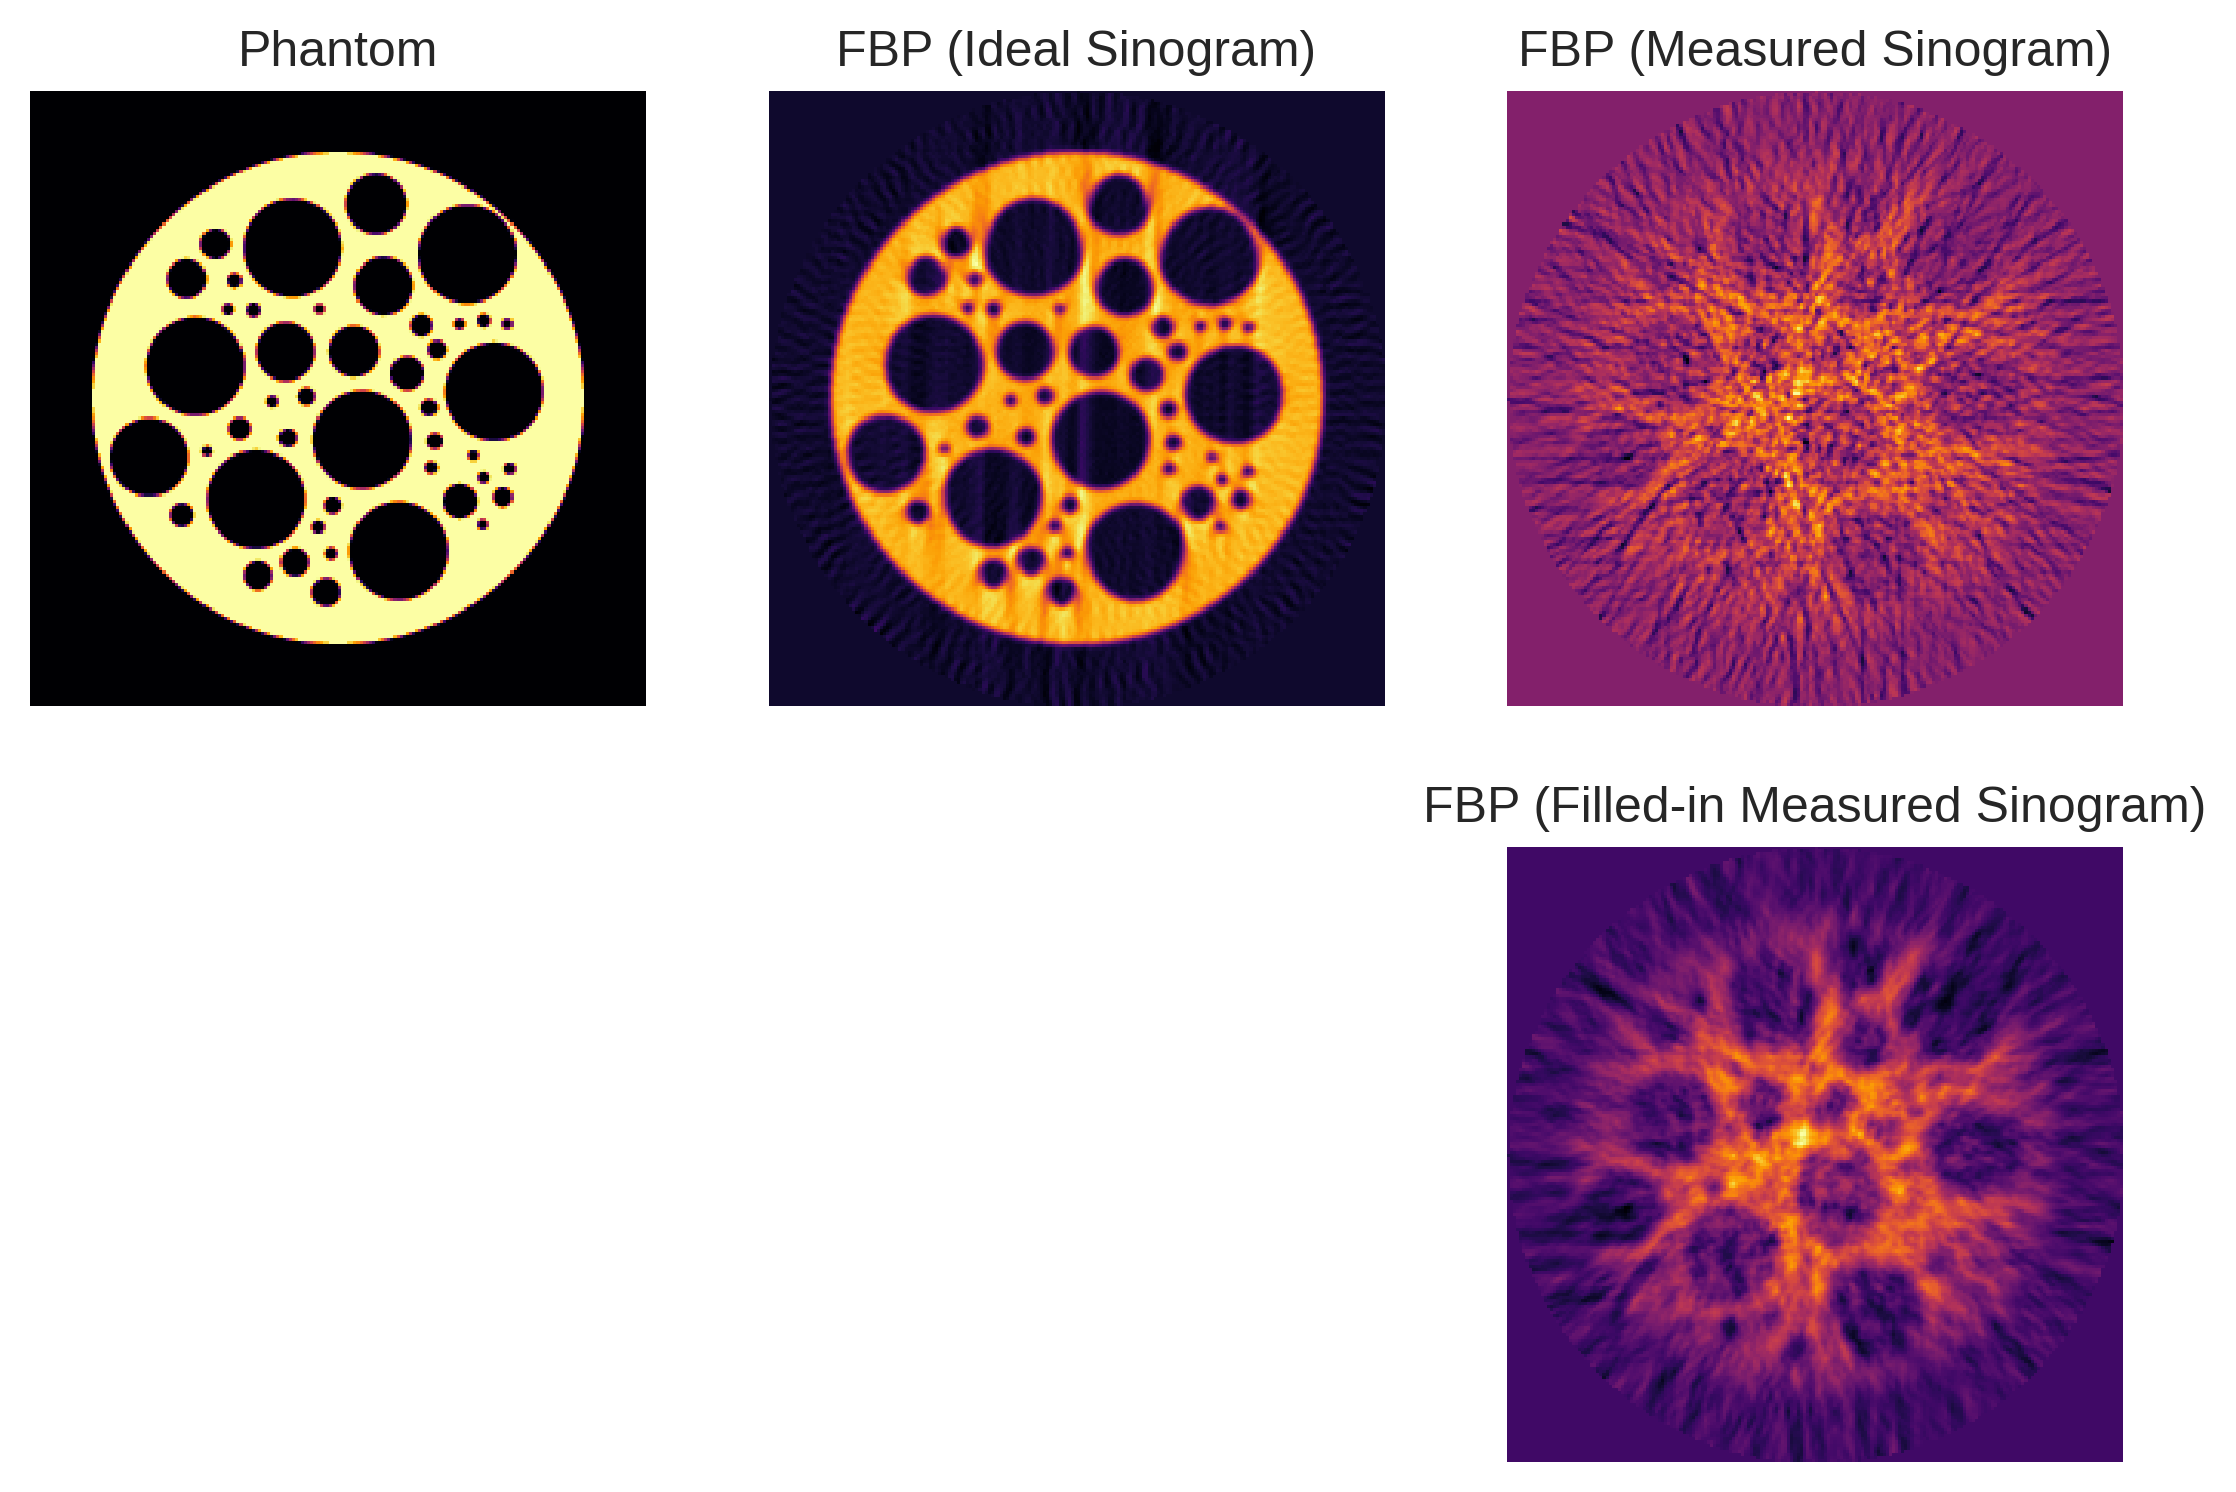

In [4]:
fbp_ideal = ski.transform.iradon(radon_image=ideal_sino, filter_name="hamming")
fbp_measured = ski.transform.iradon(radon_image=sino, filter_name="hamming")
sino_fillin = sp.ndimage.uniform_filter(sino, [wsize, 0], mode='constant')
fbp_fillin = ski.transform.iradon(radon_image=sino_fillin, filter_name="hamming")

plt.subplot(2,3,1)
plt.imshow(phantom)
plt.title('Phantom')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(fbp_ideal)
plt.title('FBP (Ideal Sinogram)')
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(fbp_measured)
plt.title('FBP (Measured Sinogram)')
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(fbp_fillin)
plt.title('FBP (Filled-in Measured Sinogram)')
plt.axis('off');

## Pyxu's Modularity to the Rescue

We now turn our attention to how Pyxu addresses the limitations encountered when using `iradon()` for reconstruction in
non-ideal conditions. Unlike monolithic approaches, Pyxu’s microservice architecture thrives on modularity, allowing us
to decompose the data model into a sequence of simple linear operators: the Radon transform ($R$), followed by filtering
($F$), masking ($M$), and finally tapering ($T$).

$$\Phi= T \circ M \circ F \circ R$$

Here is a code snippet detailing the construction of such an operator with Pyxu:

In [5]:
import pyxu.abc as pxa
import pyxu.operator as pxo
from pyxu.operator.interop import from_source
import skimage.transform as skt

# Radon Operator (imported from `skt` since Pyxu did not ship with a Radon transform at the time of this writing.)
Radon = from_source(cls=pxa.LinOp,
                    shape=(sino.size, phantom.size),
                    apply=lambda _, arr: skt.radon(arr.reshape(phantom.shape), 
                                                   theta=np.linspace(0, 180, angles), 
                                                   circle=True).ravel(),
                    adjoint=lambda _, arr: skt.iradon(arr.reshape(sino.shape), 
                                                      filter_name=None, 
                                                      circle=True).ravel(),
                    vectorize=["apply", "adjoint"], 
                    vmethod="scan", 
                    enforce_precision=["apply", "adjoint"])

# 1D Filtering
boxcar = np.asarray(sp.signal.get_window("boxcar", wsize)); boxcar /= wsize
BoxCar1D = pxo.Stencil(kernel=[boxcar, np.array([1.0])], center=(wsize // 2, 0), arg_shape=sino.shape,)

# Partial Masking
Mask = pxo.DiagonalOp(mask.ravel())

# Tapering
taper = np.outer(sp.signal.get_window("hamming", sino.shape[0]), np.ones(sino.shape[1]))
Taper = pxo.DiagonalOp(taper.ravel())

# Compose operators
Phi = Taper * Mask * BoxCar1D * Radon

Note that the `apply` and `adjoint` methods of the composite operator $\Phi$ are automatically inferred by Pyxu,
leveraging standard composition rules.

In Pyxu, one of the powerful features is the ability to define matrix-free linear operators, a crucial advantage for
large-scale imaging problems.  In layman's terms, you define an operator by just coding its `apply` and `adjoint`
methods. This bypasses the need for storing the operator as a cumbersome matrix, which not only saves memory but also
boosts computational speed when the matrix is structured.

In the example above, we have for example used the `radon()` and `iradon()` functions from `scikit-image` to define the
`apply` and `adjoint` methods of our Radon operator. This exemplifies Pyxu's core philosophy: you don't have to reinvent
the wheel; leverage useful components from other libraries when available. Pyxu is designed to stitch these disparate
elements together into a seamless, modular workflow.

Internally, Pyxu maintains a detailed record of the composition chains and arithmetic operations that define each
operator. This comprehensive tracking is made accessible through the operator's `expr()` method, which can reveal the
intricate web of calculations and transformations that the operator encompasses.

In [6]:
print(Phi.expr())

[compose, ==> LinOp(18000, 40000)
.[compose, ==> SquareOp(18000, 18000)
..[compose, ==> SquareOp(18000, 18000)
...DiagonalOp(18000, 18000),
...DiagonalOp(18000, 18000)],
..Stencil(18000, 18000)],
.LinOp(18000, 40000)]


We can now assess the effectiveness of our composite operator $\Phi$ in replicating the real-world acquisition setup.
By juxtaposing the sinogram predicted by $\Phi$ with the one actually measured, we find that the two are nearly
indistinguishable, aside from minor noise variations. This close resemblance provides strong validation for the accuracy
of our custom tomographic system model.

In [7]:
predicted_sino = Phi(phantom.ravel()).reshape(sino.shape)

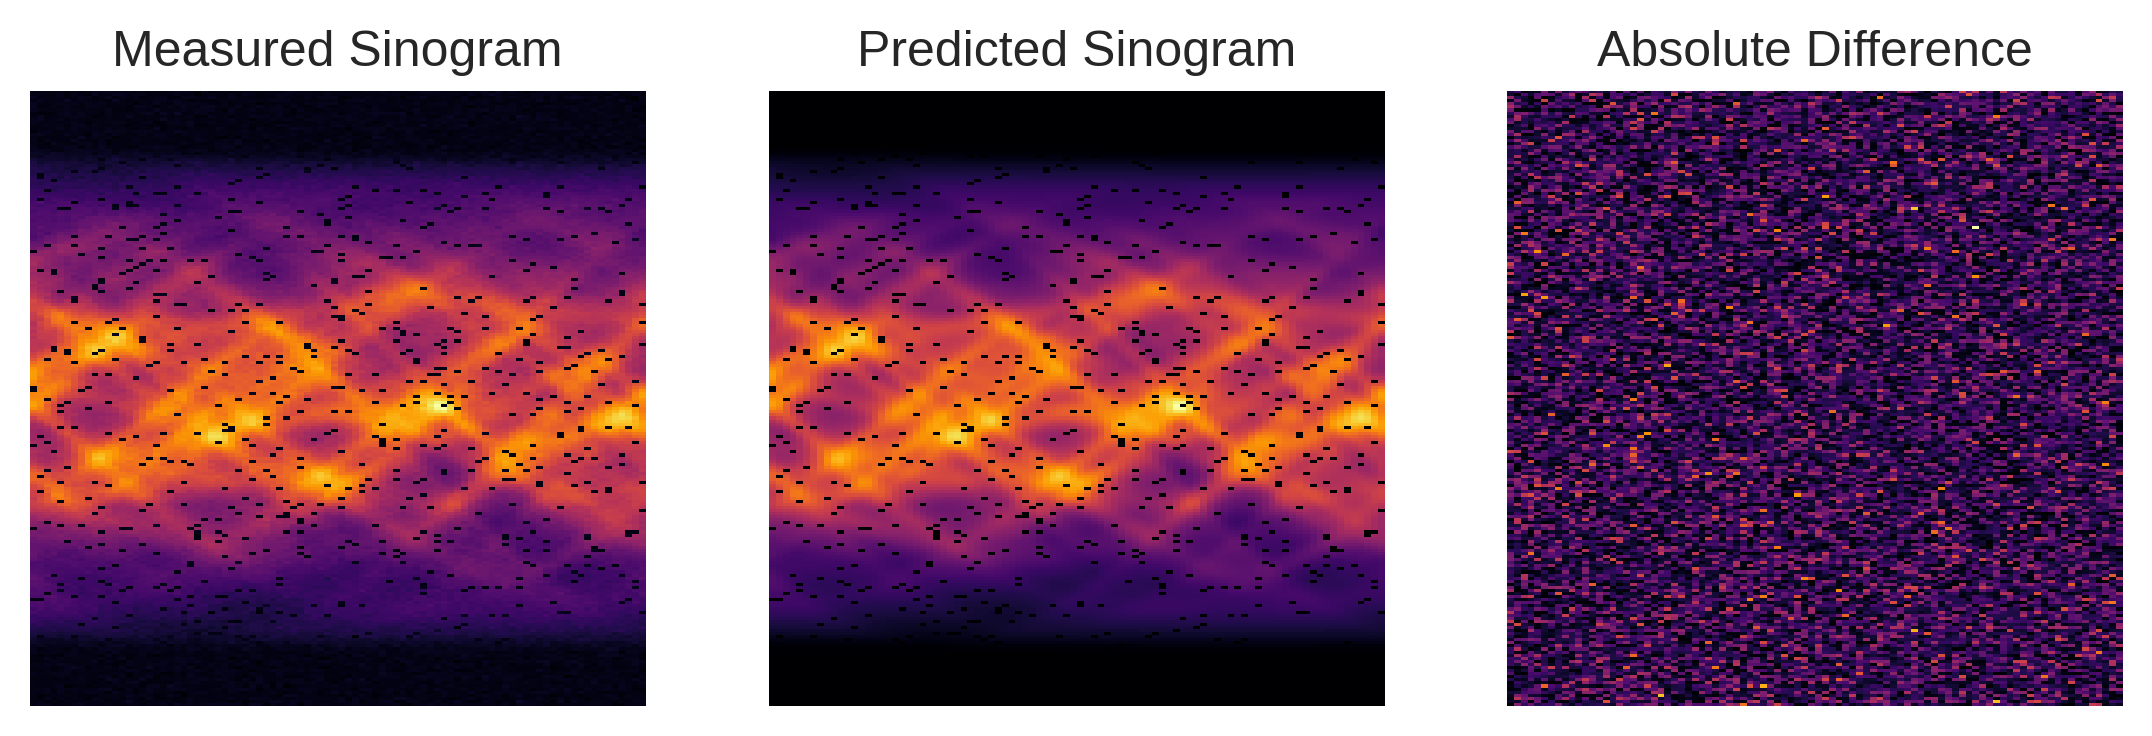

In [8]:
plt.subplot(1,3,1)
plt.imshow(sino, aspect=0.45)
plt.title("Measured Sinogram")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(predicted_sino, aspect=0.45)
plt.title("Predicted Sinogram")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.abs(sino-predicted_sino), aspect=0.45)
plt.title("Absolute Difference")
plt.axis('off');

The real strength here lies in Pyxu's ability to efficiently stitch simple generic operators together to create a
coherent and robust data model that accommodates the complexities of our specific tomographic setup. This modular design
stands in sharp contrast to adapting a one-size-fits-all routine like `iradon()` from `scikit-image`, which would
necessitate an unwieldy and complex API to account for all potential non-idealities encountered in practice.

By utilizing Pyxu's flexible architecture, we can effortlessly extend or modify each microservice to suit our needs,
making it a practical and maintainable solution for handling the intricate challenges of non-ideal image reconstruction
setups.

## Image Reconstruction with Pyxu

### Pseudoinverse Solution

Now that we've accurately modeled our acquisition system using the composite operator $\Phi$, we can proceed to the
reconstruction phase. Traditional methods like filtered backprojection are no longer applicable here due to the
complexities introduced in our custom setup. Consequently, we must resort to generic solvers such as the conjugate
gradient method to solve the corresponding (dampened) normal equations.

<center>
    
<img align="center" src="../_static/tutorial/g15273.png" alt="Forward model" width=70%>
</center>

In Pyxu, this task is greatly simplified by the `pinv()` (pseudoinverse) method provided by `LinOp` instances. The
`pinv()` method allows us to implement simple reconstruction techniques without getting lost in the details. 

The following code snippet illustrates its application in our tomographic setting. For the sake of this demonstration,
we employ a custom stopping criterion (relative error smaller than $10^{-3}$ and 500 iterations max) and incorporate a
dampening factor of 4 to improve the algorithm's resilience to noise and numerical instability.

In [9]:
import pyxu.opt.stop as pxs

stop_crit = pxs.RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) | pxs.MaxIter(500)
pinv_solution = Phi.pinv(sino.ravel(), damp=4,  
                         kwargs_init=dict(show_progress=False, verbosity=50),
                         kwargs_fit=dict(stop_crit=stop_crit))

INFO:/tmp/pyxu_wigw3osu:[2023-09-05 08:18:58.882946] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pyxu_wigw3osu:[2023-09-05 08:19:01.037832] Iteration 18
	iteration: 18
	RelError[x]: 0.0008930069037400444
	N_iter: 19.0
INFO:/tmp/pyxu_wigw3osu:[2023-09-05 08:19:01.038596] Stopping Criterion satisfied -> END


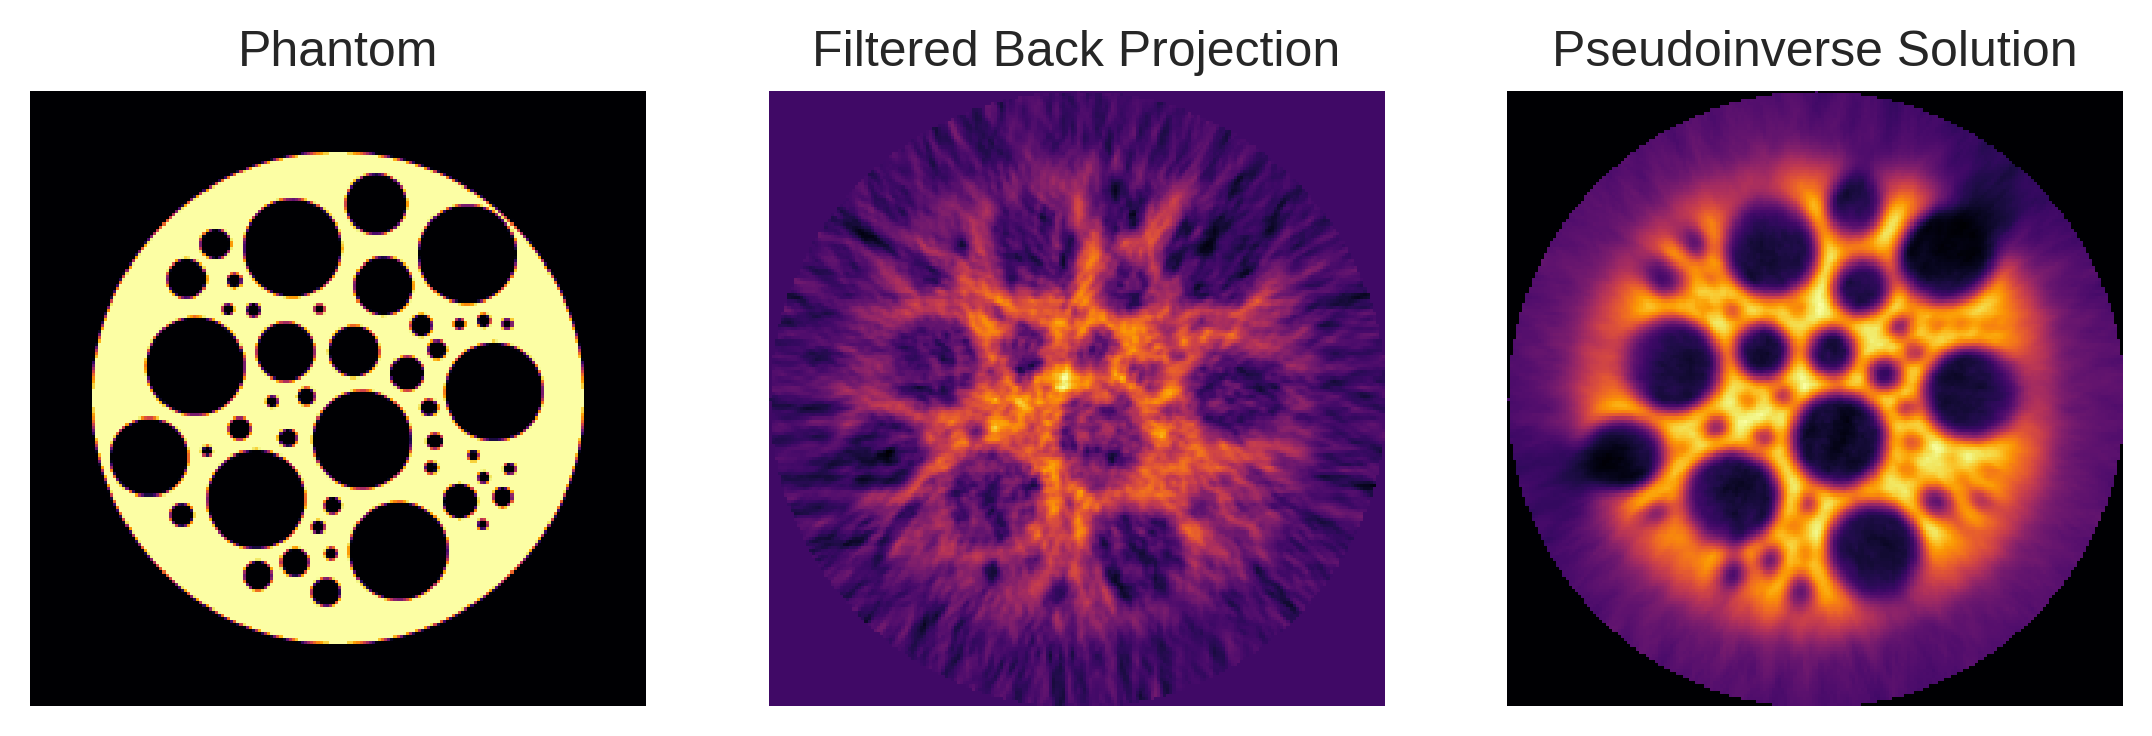

In [10]:
plt.subplot(1,3,1)
plt.imshow(phantom)
plt.title('Phantom')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(fbp_fillin)
plt.title('Filtered Back Projection')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pinv_solution.reshape(phantom.shape))
plt.title('Pseudoinverse Solution')
plt.axis('off');

The results are truly impressive! With only minimal coding, we've substantially improved various facets of image
quality, including resolution, contrast, and artifact removal.

The secret to this success lies in Pyxu's modular architecture. It enabled us to efficiently address the specific
complexities of our custom tomographic system, allowing for high-quality, reliable image reconstructions — even when
using straightforward algorithms like the conjugate gradient method.

### Bayesian Inversion

In this section, we explore a more advanced approach to image reconstruction using Bayesian models. These models offer a
rigorous yet adaptable framework to manage uncertainties and to incorporate prior information. In the Bayesian context,
the *likelihood* quantifies how well our model explains the observed data, while the *prior* encodes pre-existing
beliefs or assumptions about the solution.

<center>

<img align="center" src="../_static/tutorial/g15005.png" alt="Forward model" width=70%>
</center>

Specifically, we employ a Bayesian model with a least-squares log-likelihood, coupled with a composite prior that
includes terms for total variation, sparsity, and positivity. The corresponding (negative) log-posterior distribution is
given by:

$$
-\log p(f | g) \propto \frac{1}{2\sigma^2}\|g - \Phi(f)\|_2^2 +  \lambda\|\nabla f\|_{1} + \mu \|f\|_1 + \iota(f\geq 0).
$$

In this equation, the total variation term  $\lambda\|\nabla f\|_1$ aims to produce solutions that feature minimal
abrupt changes between adjacent pixels, which helps in preserving edges and reducing noise. The sparsity term $\mu
\|f\|_1$ encourages solutions that are primarily zero or close to zero, thereby focusing on the essential features in
the image. Lastly, the positivity constraint $f\geq 0$ ensures the reconstructed image is physically meaningful, which
is especially critical in areas like medical imaging where negative values would not be interpretable.

Unlike pseudoinverse methods, Bayesian inversion does not produce a single estimate but instead yields an *ensemble* of
possible solutions, each with varying degrees of credibility as characterized by the posterior distribution. One can
then either sample from this distribution or summarize it through its moments or modes. The mode of the posterior, known
as *Maximum A Posteriori (MAP)* estimation, provides the most credible image given the observed data, data model, and
prior. In our particular setup, the MAP estimate is defined as:

$$
\hat{f} \in \arg\min_{f\geq 0} \frac{1}{2\sigma^2}\|g - \Phi(f)\|_2^2 +  \lambda\|\nabla f\|_{1} + \mu \|f\|_1.
$$

In Pyxu, the MAP estimate can be obtained as follows.
(For simplicity, we smooth the TV term.)

In [14]:
from pyxu.operator import Gradient, SquaredL2Norm, L1Norm, PositiveL1Norm

# TV prior
grad = Gradient(arg_shape=phantom.shape, accuracy=4, mode='constant', diff_method='fd')
lambda_= 0.05 / (2 * sigma**2)
huber_norm = L1Norm(grad.shape[0]).moreau_envelope(0.01)  # We smooth the L1 norm to facilitate optimisation
tv_prior = lambda_ * huber_norm * grad

# Positivity + L1 norm 
posL1 = 0.05 * PositiveL1Norm(phantom.size)

# Loss
loss = (1/ (2 * sigma**2)) * SquaredL2Norm(dim=sino.size).asloss(sino.ravel()) * Phi

# Smooth part of the posterior
smooth_posterior = loss + tv_prior
smooth_posterior.diff_lipschitz = smooth_posterior.estimate_diff_lipschitz(method="svd", tol=0.1)

The code can be broken down as follows: 

**Defining the Total Variation (TV) Prior**
```python
# TV prior
grad = Gradient(arg_shape=phantom.shape, accuracy=4, mode='constant', diff_method='fd')
lambda_= 0.05 / (2 * sigma**2)
huber_norm = L1Norm(grad.shape[0]).moreau_envelope(0.01)
tv_prior = lambda_ * huber_norm * grad
```
- `Gradient()`: Computes the gradient of an image. The argument `arg_shape=phantom.shape` specifies the shape of the
  image, i.e., `phantom.shape`.
- `lambda_`: Scales the total variation term. It is calculated based on the noise level `sigma` in the observations.
- `moreau_envelope(0.01)`: Applies the Moreau envelope to smooth the TV term, facilitating the downstream MAP estimation
  process.

**Defining the Positivity and L1 Norm Constraints**
```python
# Positivity + L1 norm 
posL1 = 0.05 * PositiveL1Norm(phantom.size)
```
- `PositiveL1Norm()`: This operator combines a sparsity-promoting $L_1$ norm and a positivity constraint.

**Defining the Data Likelihood (Loss)**
```python
# Loss
loss = (1/ (2 * sigma**2)) * SquaredL2Norm(dim=sino.size).asloss(sino.ravel()) * Phi
```
- `SquaredL2Norm()`: Represents the squared L2 norm of the residual between the observed and modeled data, scaled by the
  noise level `sigma`.
- `.asloss(sino.ravel())`: Sets the observed sinogram as the data.
- `* Phi`: Compose the $L_2$ norm with $\Phi$, the operator modeling the acquisition process.

**Defining the Smooth Part of the Posterior**
```python
# Posterior
smooth_posterior = loss + tv_prior
smooth_posterior.estimate_diff_lipschitz(method="svd", tol=0.1)
```
- `smooth_posterior`: The smooth part of the posterior that combines both the likelihood (loss) and the smoothed
  `tv_prior`. Will be useful later on.
- `estimate_diff_lipschitz()` allows to compute the Lipschitz constant of the gradient of the differentiable part of the
  posterior. This value will be used later on to optimally set the step size of the gradient-based optimizer. This step
  can be time consuming for large scale problems.

We are now ready to solve the MAP estimation problem. We do that via proximal gradient descent (PGD), a generic solver
for problems of the form

$$
       {\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})},
$$

where $\mathcal{F}$ is *convex* and *smooth* and $\mathcal{G}$ is nonsmooth but admits a simple proximity operator.  For
our particular setup, we choose $F(f)=\frac{1}{2\sigma^2}\|g - \Phi(f)\|_2^2 +  \lambda\|\nabla f\|_{H}$ and $G(f)= \mu
\|f\|_1 + \iota(f\geq 0)$. ($\lambda\|\nabla f\|_{H}$ denotes the smoothed TV prior.)

In Pyxu, this is achieved as follows.
(Note that we do not set the solver's step size: it is automatically computed by Pyxu): 

In [20]:
from pyxu.opt.solver import PGD

# Define the solver 
solver = PGD(f=smooth_posterior, g=posL1, show_progress=False, verbosity=250)

# Call fit to trigger the solver
solver.fit(x0=0*pinv_solution.ravel(), acceleration=True, stop_crit=stop_crit)
recon_tv = solver.solution().squeeze()

INFO:/tmp/pyxu_q7cm72ey:[2023-09-05 08:30:20.184187] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pyxu_q7cm72ey:[2023-09-05 08:30:52.498540] Iteration 250
	iteration: 250
	RelError[x]: 0.0015169258712506043
	N_iter: 251.0
INFO:/tmp/pyxu_q7cm72ey:[2023-09-05 08:31:01.392924] Iteration 320
	iteration: 320
	RelError[x]: 0.000996747495385029
	N_iter: 321.0
INFO:/tmp/pyxu_q7cm72ey:[2023-09-05 08:31:01.393996] Stopping Criterion satisfied -> END


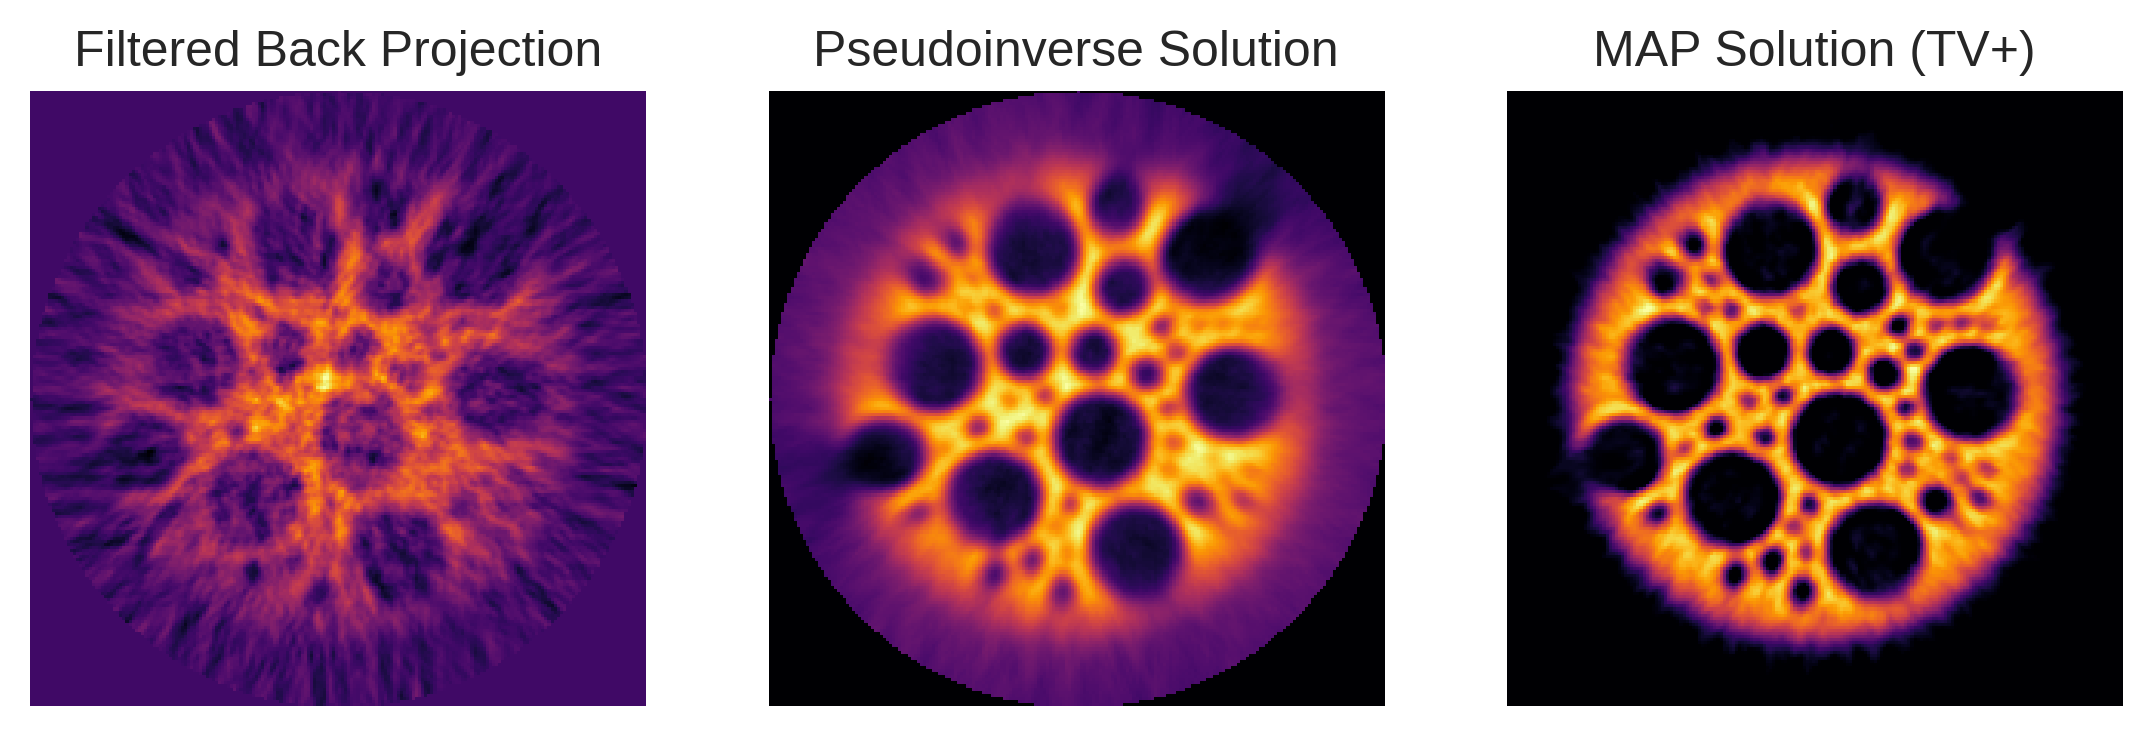

In [21]:
plt.subplot(1,3,1)
plt.imshow(fbp_fillin)
plt.title('Filtered Back Projection')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(pinv_solution.reshape(phantom.shape))
plt.title('Pseudoinverse Solution')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_tv.reshape(phantom.shape))
plt.title('MAP Solution (TV+)')
plt.axis('off');

Again, the benefits in terms of accuracy when compared to both the pseudoinverse and the naive `iradon()` reconstruction
routine are substantial. However, it's important to note that this enhanced accuracy was not achieved without some
additional effort: setting up the Bayesian inversion model is more challenging than simpler methods. Thankfully Pyxu
significantly simplifies this process by providing a streamlined framework, thereby alleviating most of the associated
complexities.

Furthermore, Pyxu offers built-in routines for fine-tuning the hyperparameters of Bayesian models — specifically the
regularization parameters $\lambda$ and $\mu$ in our case — which can further enhance the performance of the
reconstruction. Finally, for those interested in a more nuanced understanding of the solution space, Pyxu includes
Markov Chain Monte Carlo (MCMC) samplers. These allow for sampling from the posterior distribution and enable the
calculation of various statistical moments, providing a more comprehensive characterization of the solution.

### Plug-and-Play Reconstruction Schemes

We conclude this tutorial with a simple Plug-and-Play (PnP) reconstruction scheme. The latter offers a modern, versatile
approach to image reconstruction that seamlessly combines data fidelity and prior knowledge. These schemes alternate
between gradient steps, which aim to keep the solution consistent with observed data, and denoising steps, which
introduce prior information to regularize the solution.

#### PnP Priors: Implicit yet Intuitive

One of the unique characteristics of PnP schemes is the use of implicit priors. Instead of using an explicitly defined
mathematical function to model the prior, a denoising algorithm is used. This innovative step replaces the proximity
operator commonly used in classical optimization with a denoiser, thereby expanding the range of prior models that can
be incorporated into the reconstruction process. This implicitness allows for great flexibility and can accommodate more
complex structures in the data, which might not be easily expressed in mathematical terms.

The key intuition behind PnP is simple yet powerful: if a denoising algorithm can effectively remove noise from an
image, then it likely encapsulates some underlying "truth" or "structure" of the image, which can serve as a good prior.
Essentially, the denoising algorithm embodies our prior beliefs about what the solution should look like.

In real-world applications, a variety of denoising algorithms have found their way into PnP frameworks, each offering
its own set of advantages and limitations. Here are some commonly used denoisers that can act as implicit priors in PnP
schemes:

- **BM3D (Block-Matching and 3D Filtering)**: A highly effective denoiser, popular in medical imaging. It
  collaboratively filters 3D data blocks.
  
- **Non-Local Means**: Averages similar pixels from the entire image, effectively preserving textures.
  
- **Wavelet-based Denoising**: Uses wavelet transforms for multi-resolution analysis, isolating and removing noise.

- **Deep Learning-based Denoisers**: Algorithms like DnCNN adapt to various noise types and often outperform traditional
  methods.

- **Total Variation Denoising**: Minimizes the total variation of the image, effectively removing noise while keeping
  edges sharp.


#### Basic Equations
PnP methods are typically found in two forms: proximal or differentiable. 

In its proximal form, a typical PnP algorithm can be represented by:

$$
f^{k+1} = \text{Denoiser}_{\sigma}(f^k - \tau \nabla F(f^k)),
$$
where $\nabla F(x)$ is the gradient term ensuring data fidelity.

In differential form, influenced by the regularization by denoising ([RED](https://arxiv.org/abs/1611.02862)) framework,
the equation can be expressed as:

$$
f^{k+1} = f^k - \tau \left[\nabla F(f^k) + \lambda(f^k- \text{Denoiser}_{\sigma}(f^k))\right],
$$
where $\lambda$ encodes the PnP prior strength. 

> **_NOTE:_** Tweedie's formula tells us that when $\text{Denoiser}_{\sigma}$ is an MMSE Gaussian denoiser, we should
> choose $\lambda = 1/\sigma$ (where $\sigma$ is the noise level). The term $\frac{1}{\sigma}(f^k-
> \text{Denoiser}_{\sigma}(f^k))$ can then be understood as the    approximate score (gradient) of the distribution of
> natural images convolved with a Gaussian with standard deviation $\sigma$. 

By understanding and applying these principles, one can utilize PnP schemes to achieve high-quality image
reconstructions that are both data-consistent and regularized, all while benefiting from the computational and modeling
advantages that come with implicit priors.

In Pyxu, implicit PnP priors can be implemented in both forms via the `ProxDiffFunc()` base class. Here is a simple
example with a median filter denoiser. 

In [22]:
from scipy.ndimage import median_filter

def denoiser(arr, arg_shape, wsize):
    arr = arr.reshape(arg_shape)
    return median_filter(arr, size=wsize).ravel()

class MedianFilterPnP(pxa.ProxDiffFunc):
    def __init__(self, arg_shape, wsize):
        super().__init__((1, np.prod(arg_shape)))
        self._arg_shape = arg_shape
        self.wsize= wsize
        self.diff_lipschitz = 1
    
    def apply(self, arr):
        return NotImplemented  # PnP priors are implicit: they do not have an apply method! 
    
    def grad(self, arr): 
        return arr - denoiser(arr, self._arg_shape, self.wsize)  # Differential form 

    def prox(self, arr, tau=None):  # `tau`` is not used since this is not a proper proximal operator.
        return denoiser(arr, self._arg_shape, self.wsize)  # Proximal form    

> Note that this is a simplified implementation for example purposes. An actual implmentation would need to abide by
> Pyxu's API rules, namely support for batch dimensions, module-agnosticity and precision control).

We can now initialize the PnP prior: 

In [23]:
medpnp = MedianFilterPnP(phantom.shape, (3,3))

For the data consistency term, we simply use the least-squares loss from before. To allow for PGD to tune its gradient
step automatically, we need to compute the Lipschtiz constant of the derivative of the loss:

In [24]:
loss.diff_lipschitz = loss.estimate_diff_lipschitz(method="svd", tol=0.1)

To use the PnP prior in proximal form, we feed it to the nonsmooth proximal term `g` of PGD:

In [25]:
# Define the solver 
solver = PGD(f=loss, g=medpnp, show_progress=False, verbosity=75)

# Call fit to trigger the solver
solver.fit(x0=pinv_solution.ravel(), acceleration=True, stop_crit=pxs.MaxIter(250))
recon_pnp_prox = solver.solution().squeeze()

INFO:/tmp/pyxu_b8d_bmhj:[2023-09-05 08:41:25.913682] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_b8d_bmhj:[2023-09-05 08:41:35.225395] Iteration 75
	iteration: 75
	N_iter: 76.0
INFO:/tmp/pyxu_b8d_bmhj:[2023-09-05 08:41:44.234359] Iteration 150
	iteration: 150
	N_iter: 151.0
INFO:/tmp/pyxu_b8d_bmhj:[2023-09-05 08:41:53.308468] Iteration 225
	iteration: 225
	N_iter: 226.0
INFO:/tmp/pyxu_b8d_bmhj:[2023-09-05 08:41:56.387729] Iteration 250
	iteration: 250
	N_iter: 251.0
INFO:/tmp/pyxu_b8d_bmhj:[2023-09-05 08:41:56.388316] Stopping Criterion satisfied -> END


> Note that we changed the stopping criterion to a maximum number of iterations, since the fixed-point convergence of
> PnP methods is not guaranteed in general.

To use the PnP prior in differential form, we first sum it with the loss and feed the sum to the smooth term `f` of PGD,
leaving the nonsmooth term empty:

In [26]:
# Define new composite smooth term (sum of the loss and weighted implicit prior) 
composite_smooth = loss + 0.1 * medpnp

# Define the solver 
solver = PGD(f=composite_smooth, g=None, show_progress=False, verbosity=75)

# Call fit to trigger the solver
solver.fit(x0=pinv_solution.ravel(), acceleration=True, stop_crit=pxs.MaxIter(250))
recon_pnp_smooth = solver.solution().squeeze()

INFO:/tmp/pyxu_ifaau7xq:[2023-09-05 08:42:12.851823] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_ifaau7xq:[2023-09-05 08:42:22.290988] Iteration 75
	iteration: 75
	N_iter: 76.0
INFO:/tmp/pyxu_ifaau7xq:[2023-09-05 08:42:31.598315] Iteration 150
	iteration: 150
	N_iter: 151.0
INFO:/tmp/pyxu_ifaau7xq:[2023-09-05 08:42:41.080073] Iteration 225
	iteration: 225
	N_iter: 226.0
INFO:/tmp/pyxu_ifaau7xq:[2023-09-05 08:42:44.258842] Iteration 250
	iteration: 250
	N_iter: 251.0
INFO:/tmp/pyxu_ifaau7xq:[2023-09-05 08:42:44.259926] Stopping Criterion satisfied -> END


The results are given below:

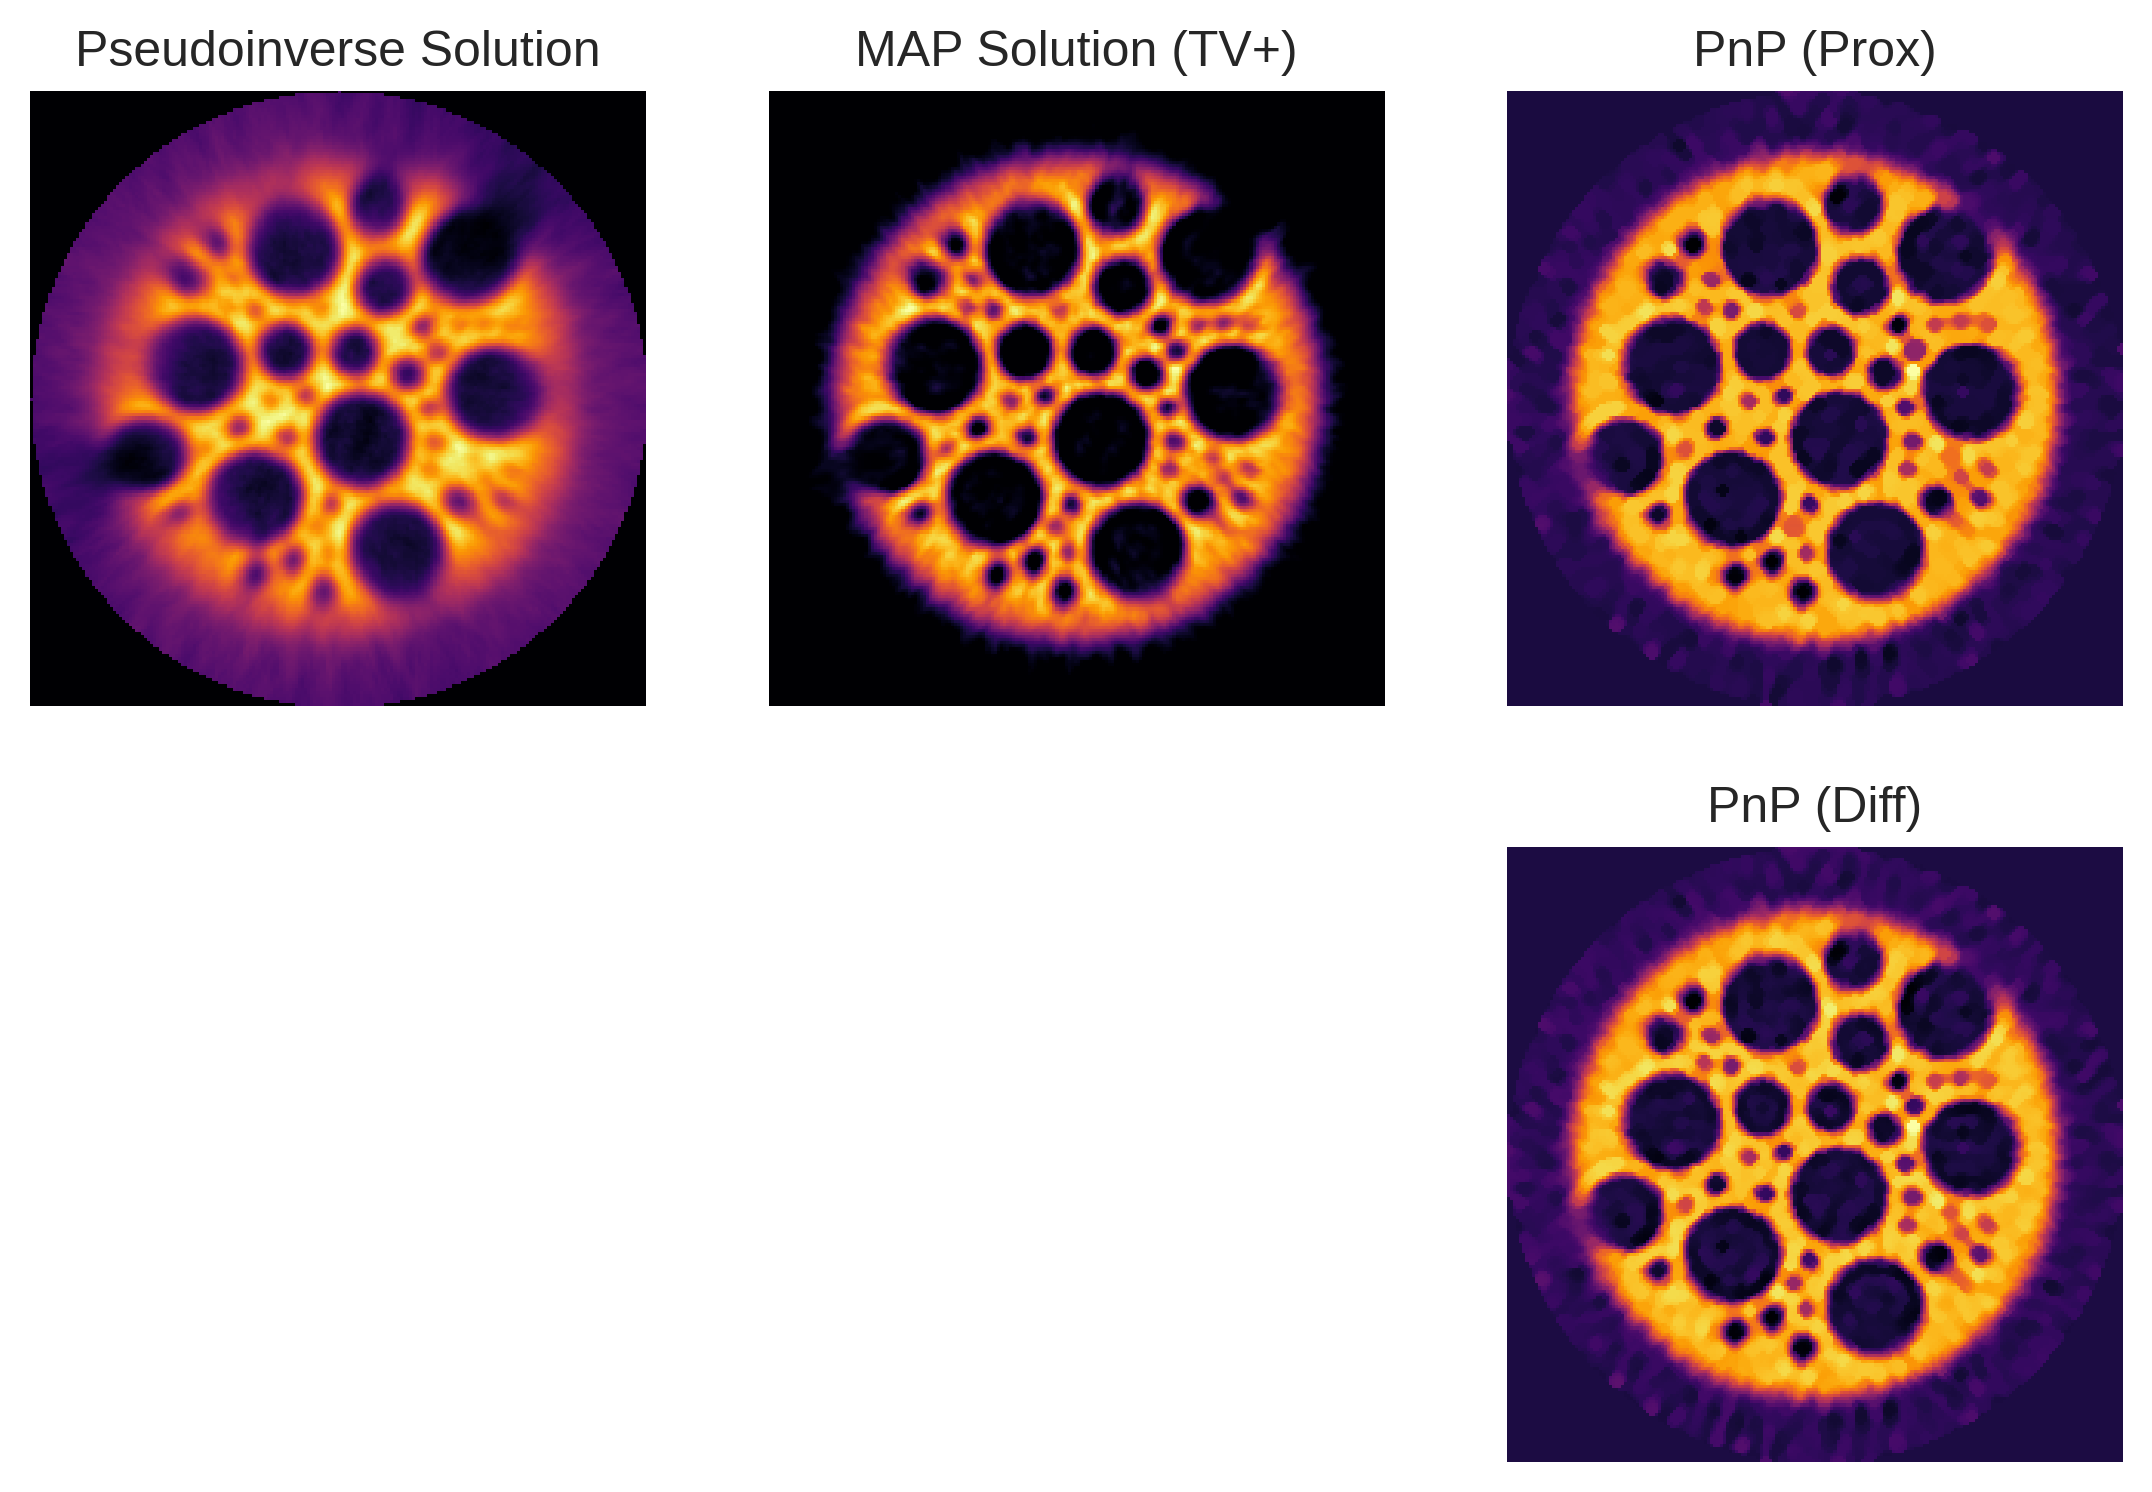

In [27]:
plt.subplot(2,3,1)
plt.imshow(pinv_solution.reshape(phantom.shape))
plt.title('Pseudoinverse Solution')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(recon_tv.reshape(phantom.shape))
plt.title('MAP Solution (TV+)')
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(recon_pnp_prox.reshape(phantom.shape))
plt.title('PnP (Prox)')
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(recon_pnp_smooth.reshape(phantom.shape))
plt.title('PnP (Diff)')
plt.axis('off');

Not bad! Despite using a very simple PnP prior, we managed to significantly improve the reconstruction quality w.r.t.
the pseudoinverse solution. With respect to the MAP solution, we observe a slight improvement in terms of sharpness and
contrast. There is however not much difference between the PnP priors in differential or proximal form. 

Note however that PnP priors are harder to fine-tune than Bayesian methods. In particular, the size of the median filter
used above is arbitrary, and changing it can significantly change the estimate: 

In [28]:
medpnp = MedianFilterPnP(phantom.shape, (5, 5))

In [29]:
# Define the solver 
solver = PGD(f=loss, g=medpnp, show_progress=False, verbosity=75)

# Call fit to trigger the solver
solver.fit(x0=pinv_solution.ravel(), acceleration=True, stop_crit=pxs.MaxIter(250))
recon_pnp_prox = solver.solution().squeeze()

INFO:/tmp/pyxu_h7p7jo96:[2023-09-05 08:43:42.681462] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_h7p7jo96:[2023-09-05 08:43:52.902673] Iteration 75
	iteration: 75
	N_iter: 76.0
INFO:/tmp/pyxu_h7p7jo96:[2023-09-05 08:44:02.596786] Iteration 150
	iteration: 150
	N_iter: 151.0
INFO:/tmp/pyxu_h7p7jo96:[2023-09-05 08:44:12.418049] Iteration 225
	iteration: 225
	N_iter: 226.0
INFO:/tmp/pyxu_h7p7jo96:[2023-09-05 08:44:15.650613] Iteration 250
	iteration: 250
	N_iter: 251.0
INFO:/tmp/pyxu_h7p7jo96:[2023-09-05 08:44:15.651198] Stopping Criterion satisfied -> END


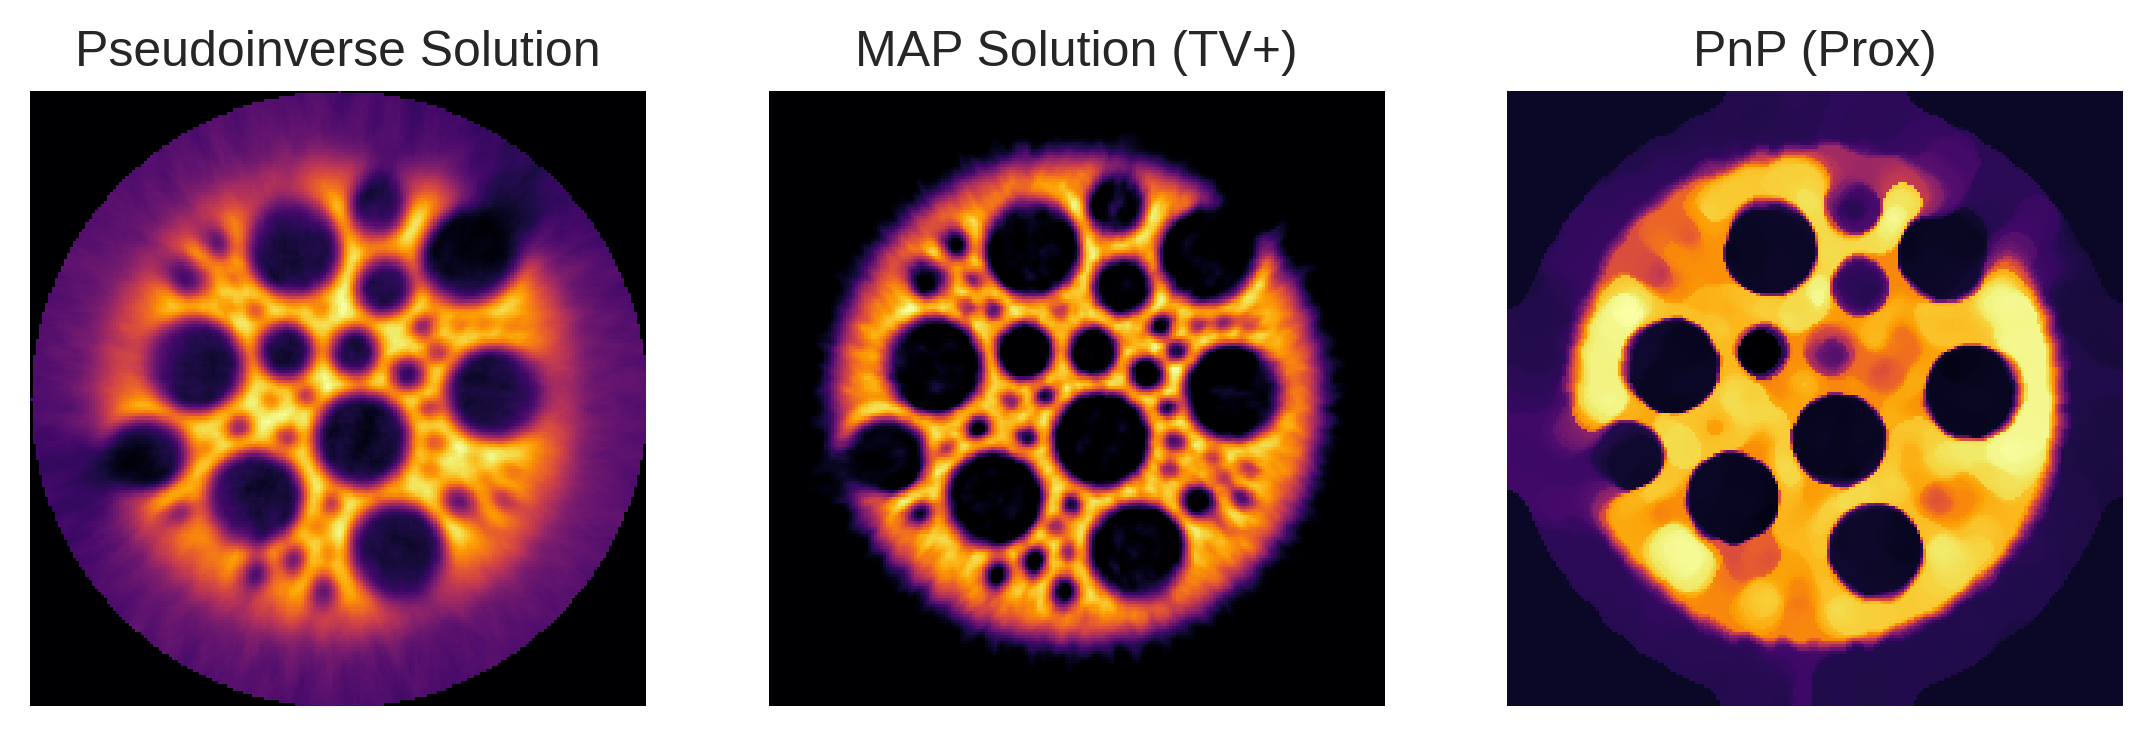

In [30]:
plt.subplot(1,3,1)
plt.imshow(pinv_solution.reshape(phantom.shape))
plt.title('Pseudoinverse Solution')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(recon_tv.reshape(phantom.shape))
plt.title('MAP Solution (TV+)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_pnp_prox.reshape(phantom.shape))
plt.title('PnP (Prox)')
plt.axis('off');

The resulting image looks "sketchy" and extremely quantized. Lots of details are lost w.r.t the MAP solution. (Only the
big dark circles subsist.)